## Temat: Otoczka wypukła dla zbioru punktów w przestrzeni dwuwymiarowej

## Autorzy: Kamil Wiśniewski i Tomasz Boroń

#### Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

#### Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

#### Import matplotlib do wizualizacji

In [3]:
%matplotlib notebook

#### Generacja zbiorów punktów

#### Punkty losowo wybrane z prostokąta (x0,x1) x (y0,y1)

In [4]:
from random import random
from math import sin,cos,pi
from random import randint

p1=[]
def rand1(amount,x0,x1,y0,y1,scenesGen):
    p1.clear()
    for i in range(amount):
        p1.append(( random()*(x1-x0)+x0 , random()*(y1-y0)+y0 ))
    scenesGen.append(Scene([PointsCollection(p1,color="blue")]))

def rand1_time(amount,x0,x1,y0,y1):
    p1.clear()
    for i in range(amount):
        p1.append(( random()*(x1-x0)+x0 , random()*(y1-y0)+y0 ))

#### Punkty na okręgu o podanym środku i promieniu

In [5]:
p2=[]
def rand2(amount,x0,y0,R,scenesGen):
    p2.clear()
    for i in range(amount):
        angle=random()*2*pi
        p2.append((x0+R*cos(angle),y0+R*sin(angle)))
    scenesGen.append(Scene([PointsCollection(p2,color="blue")]))
    
def rand2_time(amount,x0,y0,R):
    p2.clear()
    for i in range(amount):
        angle=random()*2*pi
        p2.append((x0+R*cos(angle),y0+R*sin(angle)))

#### Punkty na bokach prostokąta o podanych wierzchołkach

In [6]:
p3=[]
def rand3(amount,point1,point2,point3,point4,scenesGen): # od lewego górnego zgodnie z ruchem wskazówek zegara
    p3.clear()
    for i in range(amount):
        x=randint(1,4)
        if x==1:
            p3.append((random()*(point2[0]-point1[0])+point1[0],point1[1])) # górny bok
        elif x==2:
            p3.append((point2[0],random()*(point2[1]-point3[1])+point3[1])) # prawy bok
        elif x==3:
            p3.append((random()*(point3[0]-point4[0])+point4[0],point3[1])) # dolny bok
        else:
            p3.append((point4[0],random()*(point1[1]-point4[1])+point4[1])) # lewy bok
    scenesGen.append(Scene([PointsCollection(p3,color="blue")]))
    
def rand3_time(amount,point1,point2,point3,point4): # od lewego górnego zgodnie z ruchem wskazówek zegara
    p3.clear()
    for i in range(amount):
        x=randint(1,4)
        if x==1:
            p3.append((random()*(point2[0]-point1[0])+point1[0],point1[1])) # górny bok
        elif x==2:
            p3.append((point2[0],random()*(point2[1]-point3[1])+point3[1])) # prawy bok
        elif x==3:
            p3.append((random()*(point3[0]-point4[0])+point4[0],point3[1])) # dolny bok
        else:
            p3.append((point4[0],random()*(point1[1]-point4[1])+point4[1])) # lewy bok

#### Punkty generowane dla kwadratu o podanych wierzchołkach, ilości punktów na osiach i przekątnych 

In [7]:
p4=[] 
def rand4(amount_axle,amount_diag,point1,point2,point3,point4,scenesGen):
    p4.clear()
    for i in range(amount_diag):
        s=random()
        t=random()
        x1=(point2[0]-point4[0])*s+point4[0]
        y1=(point2[1]-point4[1])*s+point4[1]
        x2=(point1[0]-point3[0])*t+point3[0]
        y2=(point1[1]-point3[1])*t+point3[1]
        p4.append((x1,y1))
        p4.append((x2,y2)) 
    p4.append(point1)
    p4.append(point2)
    p4.append(point3)
    p4.append(point4)
    for i in range(amount_axle):
        p4.append((point4[0],random()*(point1[1]-point4[1])+point4[1]))
        p4.append((random()*(point3[0]-point4[0])+point4[0],point4[1]))
    scenesGen.append(Scene([PointsCollection(p4,color="blue")]))
    
def rand4_time(amount_axle,amount_diag,point1,point2,point3,point4):
    p4.clear()
    for i in range(amount_diag):
        s=random()
        t=random()
        x1=(point2[0]-point4[0])*s+point4[0]
        y1=(point2[1]-point4[1])*s+point4[1]
        x2=(point1[0]-point3[0])*t+point3[0]
        y2=(point1[1]-point3[1])*t+point3[1]
        p4.append((x1,y1))
        p4.append((x2,y2)) 
    p4.append(point1)
    p4.append(point2)
    p4.append(point3)
    p4.append(point4)
    for i in range(amount_axle):
        p4.append((point4[0],random()*(point1[1]-point4[1])+point4[1]))
        p4.append((random()*(point3[0]-point4[0])+point4[0],point4[1]))

#### Punkty leżące na ćwiartce okręgu o podanym środku oraz środek tego okręgu

In [8]:
p5=[]
def rand5(amount,x0,y0,R,scenesGen):
    p5.clear()
    p5.append((x0,y0))
    for i in range(amount):
        angle=random()*(pi/2)
        p5.append((x0+R*cos(angle),y0+R*sin(angle)))
    scenesGen.append(Scene([PointsCollection(p5,color="blue")]))
    
def rand5_time(amount,x0,y0,R):
    p5.clear()
    p5.append((x0,y0))
    for i in range(amount):
        angle=random()*(np.pi/2)
        p5.append((x0+R*np.cos(angle),y0+R*np.sin(angle)))

#### Miejsce do zadawania własnych zbiorów punktów (należy uruchomić obie następne komórki - pierwsza służy do rysowania, a druga zapisze punkty w strukturze)

<IPython.core.display.Javascript object>


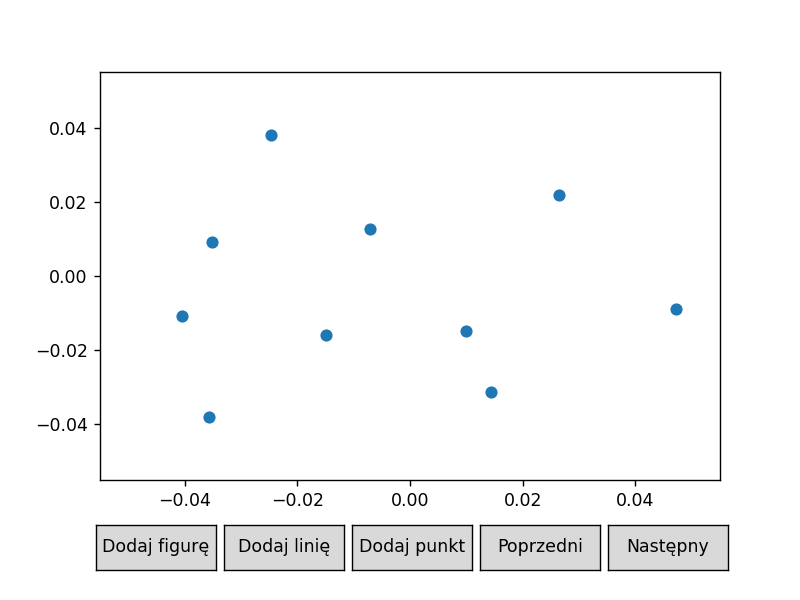

In [9]:
# Dodawanie punktów poprzez przycisk dodaj punkt

p6=[]
plotGen=Plot(points=[PointsCollection([(0, 0)], color='white')])
plotGen.draw()

In [10]:
p6=plotGen.get_added_points()[0].points
print(p6)

[(-0.024647432142688393, 0.038073683626511534), (-0.035070819239462585, 0.009090840489256638), (0.02636063237344065, 0.021897213038276242), (-0.007127270852365808, 0.012797948332393894), (0.014384825921827743, -0.03135033598133162), (0.04720740656698903, -0.008770679118586505), (-0.01488936762655936, -0.01584788500093945), (-0.035736141820107745, -0.03809053205976299), (-0.04039339988462388, -0.010792737942115924), (0.009949342050859997, -0.014836855589174747)]


#### Słownik zbiorów i ich generacja do użycia w programie

<IPython.core.display.Javascript object>


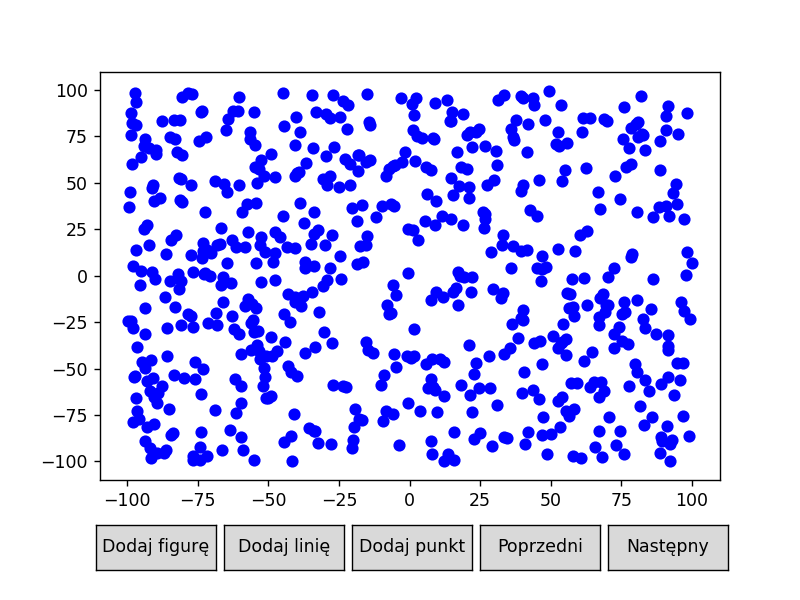

In [11]:
# zbiór, który podajemy jako parametr algorymtów - jego opis
# p1 - punkty wewnątrz prostokąta
# p2 - punkty na okręgu
# p3 - punkty na bokach prostokąta
# p4 - punkty na dwóch bokach i przekątynch kwadratu
# p5 - środek okręgu i punkty na ćwiartce okręgu
# p6 - zbiór domyślny, rysowany samodzielnie, obsługiwany powyżej

# ------------------------------------------------------

# GENERACJA, odkomentować zbiory, których chce się użyć

# rand_numer_ odpowiada p_numer_ z powyższego słownika zbiorów

# Opis argumentów dla konkretnych generatorów
# rand1(liczba punktów,lewa granica x,prawa granica x,lewa granica y,prawa granica y)
# rand2(liczba punktów,położenie x środka,położenie y środka,promień okręgu)
# rand3(liczba punktów,lewy górny róg prostokąta,prawy górny,prawy dolny,lewy dolny)
# rand4(liczba punktów na bokach,liczba punktów na przekątnych,lewy górny róg kwadratu,prawy górny,prawy dolny,lewy dolny)
# rand5(liczba punktów,położenie x środka,położenie y środka,promień okręgu)

scenesGen=[]
rand1(625,-100,100,-100,100,scenesGen)
rand2(30,0,0,10000,scenesGen)
rand3(70,(-60,30),(20,30),(20,-80),(-60,-80),scenesGen)
rand4(10,10,(-300,200),(300,200),(300,-400),(-300,-400),scenesGen)
rand5(80,0,0,100000,scenesGen)

# przewijanie przyciskiem następny wyświetla kolejne wygenerowane zbiory

plotGen=Plot(scenes = scenesGen)
plotGen.draw() 

#### Funkcje pomocniczne

#### Dokładność 0

In [12]:
eps=10**(-8)

#### Wyznacznik 3x3

In [13]:
def orient(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - c[0] * b[1] - c[1] * a[0] - b[0] * a[1]

#### Znak wyznacznika

In [14]:
def orientSign(a,b,c):
    value=orient(a,b,c)
    if value<-eps: return -1
    elif value>eps: return 1
    else: return 0

#### Iloczyn skalarny

In [15]:
def scalar(a,b,c):
    return (b[0]-a[0])*(c[0]-a[0])+(b[1]-a[1])*(c[1]-a[1])

#### Długość wektora

In [16]:
from math import sqrt

def vectorLen(a,b):
    return sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)

#### Sortowanie punktów po współrzędnej kątowej

In [17]:
def partition(p,p0,start,end):
    pivot = p[end]
    i = start - 1
    for j in range(start, end):
        if orient(p0, pivot, p[j]) < -eps:
            i += 1
            p[i], p[j] = p[j], p[i]
    p[i + 1], p[end] = p[end], p[i + 1]
    return i+1

In [18]:
def sortpoints(p, p0, start, end):
    if start<end:
        d=partition(p,p0,start,end)
        sortpoints(p, p0, start, d-1)
        sortpoints(p, p0, d + 1, end)

#### Usuwanie współliniowych

In [19]:
def delColinear(p):
    i=1
    while i<len(p)-1:
        if orient(p[0],p[i],p[i+1])>=-eps and orient(p[0],p[i],p[i+1])<=eps:
            if vectorLen(p[0],p[i])>vectorLen(p[0],p[i+1]):
                p.pop(i+1)
            else: p.pop(i)
        else:
            i+=1

#### Sprawdzanie czy punkt znajduje się wewnątrz figury

In [20]:
def inside(f,p):
    for i in range(len(f)):
        if orient(f[i],f[(i+1)%len(f)],p)<-eps: 
            return False
    return True

#### Odległość punktu od prostej

In [21]:
def distance(point,a,b):
    x1=a[0]
    y1=a[1]
    x2=b[0]
    y2=b[1]
    A=y2-y1
    B=x1-x2
    C=x2*y1-y2*x1
    x0=point[0]
    y0=point[1]
    return abs(A*x0+B*y0+C)/sqrt(A*A+B*B)

## Algorytm Grahama

#### Wersja z wizualizacją

In [22]:
scenes=[]

def Graham(p,save):
    if len(p)<3: return p
    scenes.clear()
    pcopy=[]
    pcopy.extend(p)
    scenes.append(Scene([PointsCollection(p,color="blue")]))
    stack = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    sortpoints(pcopy, pcopy[0],1,len(pcopy)-1)  # sortowanie po współrzędnej kątowej
    scenes.append(Scene([PointsCollection(p,color="blue"),
                         PointsCollection([pcopy[0]],color="red"),
                         PointsCollection([pcopy[1]],color="green")
                       ]))
    delColinear(pcopy)  # usuwanie współliniowych
    if len(pcopy)<3: return p
    scenes.append(Scene([PointsCollection(pcopy,color="blue") # dodatkowa wizualizacja pokazująca bez współliniowych (z p0)
                       ]))
    stack.append(pcopy[0])
    stack.append(pcopy[1])
    stack.append(pcopy[2])
    lines=[(stack[x],stack[x+1]) for x in range(len(stack)-1)]
    scenes.append(Scene([PointsCollection(p)],
                        [LinesCollection(lines[0:len(lines)],color="red")
                       ]))
    i = 3
    while i < len(pcopy):
        p2 = stack.pop(-1)
        p1 = stack.pop(-1)
        stack.append(p1)
        stack.append(p2)
        lines=[(stack[x],stack[x+1]) for x in range(len(stack)-1)]
        scenes.append(Scene([PointsCollection(p)],
                            [LinesCollection(lines[0:len(lines)],color="red"),
                             LinesCollection([(stack[len(stack)-2],stack[len(stack)-1])],color="blue"),
                             LinesCollection([(stack[len(stack)-1],pcopy[i])],color="green")
                       ]))
        if orient(p1, p2, pcopy[i]) > eps:
            stack.append(pcopy[i])
            i += 1
        else:
            stack.pop(-1)
    hull = []
    while not len(stack)==0:
        hull.append(stack.pop(-1))
    hull.reverse()
    for i in range(len(hull)):
        lines.append([hull[i%len(hull)],hull[(i+1)%len(hull)]])
        scenes.append(Scene([PointsCollection(p,color="lime"),
                         PointsCollection(hull,color="red")],
                        [LinesCollection(lines[0:i])
                       ]))
    scenes.append(Scene([PointsCollection(p,color="lime"),
                        PointsCollection(hull,color="red")],
                        [LinesCollection(lines)
                       ]))
    if save:
        saveFile(hull,"GrahamResult")
    return hull

#### Wersja do pomiaru czasu

In [23]:
def Graham_To_Measure_Time(p,save):
    if len(p)<3: return p
    pcopy=[]
    pcopy.extend(p)
    stack = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    sortpoints(pcopy, pcopy[0],1,len(pcopy)-1)  # sortowanie po współrzędnej kątowej
    delColinear(pcopy)  # usuwanie współliniowych
    if len(pcopy)<3: return p
    stack.append(pcopy[0])
    stack.append(pcopy[1])
    stack.append(pcopy[2])
    i = 3
    while i < len(pcopy):
        p2 = stack.pop(-1)
        p1 = stack.pop(-1)
        stack.append(p1)
        stack.append(p2)
        if orient(p1, p2, pcopy[i]) > eps:
            stack.append(pcopy[i])
            i += 1
        else:
            stack.pop(-1)
    hull = []
    while not len(stack)==0:
        hull.append(stack.pop(-1))
    if save:
        saveFile(hull,"GrahamResult")
    hull.reverse()
    return hull

## Algorytm Jarvisa

#### Wersja z wizualizacją

In [24]:
from math import inf

scenesj=[]

def Jarvis(p,save):
    scenesj.clear()
    pcopy=[]
    pcopy.extend(p)
    scenesj.append(Scene([PointsCollection(p,color="blue")]))
    hull = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    scenesj.append(Scene([PointsCollection(p,color="blue"),
                         PointsCollection([pcopy[0]],color="red")
                       ]))
    linesj=[]
    hull.append(pcopy[0])
    i0 = pcopy[0]
    prev=i0
    i=(prev[0]+eps,prev[1]) # pierwszy wektor od którego liczę kąt
    while not i == i0:
        long=(2*i[0]-prev[0],2*i[1]-prev[1])  
        if len(hull)>2 and orient(hull[-3],hull[-2],hull[-1])>=-eps and orient(hull[-3],hull[-2],hull[-1])<=eps:
            hull.pop(-2)  # zdejmowanie współliniowych
        kval = -1         # początkowe wartości aby znaleźć punkt - dlaczego takie, opisane w sprawozdaniu wstęp teoretyczny
        kpoint = (inf, inf)
        for j in pcopy:
            if not j == i and not j == prev:
                currentvalue=scalar(i,long,j)/(vectorLen(i,long)*vectorLen(i,j)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if currentvalue>kval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    kval = currentvalue
                    kpoint = j
        hull.append(kpoint)
        prev = i
        i = kpoint
    for n in range(len(hull)):
        linesj.append([hull[n%len(hull)],hull[(n+1)%len(hull)]])
        scenesj.append(Scene([PointsCollection(p,color="lime"),
                         PointsCollection(hull,color="red")],
                        [LinesCollection(linesj[0:n])
                       ]))
    scenesj.append(Scene([PointsCollection(p,color="lime"),
                        PointsCollection(hull,color="red")],
                        [LinesCollection(linesj)
                       ]))
    if save:
        saveFile(hull,"JarvisResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    return hull

#### Wersja do pomiaru czasu

In [25]:
from math import inf

def Jarvis_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    hull = []
    pcopy.sort(key=lambda x: x[0])
    pcopy.sort(key=lambda x: x[1])
    hull.append(pcopy[0])
    i0 = pcopy[0]
    prev=i0
    i=(prev[0]+eps,prev[1]) # pierwszy wektor od którego liczę kąt
    while not i == i0:
        long=(2*i[0]-prev[0],2*i[1]-prev[1])  
        if len(hull)>2 and orient(hull[-3],hull[-2],hull[-1])>=-eps and orient(hull[-3],hull[-2],hull[-1])<=eps:
            hull.pop(-2)  # zdejmowanie współliniowych
        kval = -1         # początkowe wartości aby znaleźć punkt - dlaczego takie, opisane w sprawozdaniu wstęp teoretyczny
        kpoint = (inf, inf)
        for j in pcopy:
            if not j == i and not j == prev:
                currentvalue=scalar(i,long,j)/(vectorLen(i,long)*vectorLen(i,j)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if currentvalue>kval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    kval = currentvalue
                    kpoint = j
        hull.append(kpoint)
        prev = i
        i = kpoint
    if save:
        saveFile(hull,"JarvisResult")
    #print(hull) #usunąć komentarz w celu wypisania punktów poniżej w programie
    return hull

## Algorytm przyrostowy

#### Wersja z wizualizacją

In [26]:
scenesi=[]

def Incremental(p,save):
    scenesi.clear()
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    scenesi.append(Scene([PointsCollection(p,color="blue")]))
    if len(pcopy)<3: return pcopy
    hull=pcopy[0:3]
    if orientSign(hull[0],hull[1],hull[2])<0:
        hull[1],hull[2]=hull[2],hull[1]
    for i in range(3,len(p)):
        point=pcopy[i]
        if inside(hull,point):
            scenesi.append(Scene([PointsCollection(pcopy,color="blue"),
                              PointsCollection([point],color="yellow")],
                              [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))])]))
            continue
        t1=-1  # indeksy stycznych
        t2=-1
        colinear=False
        for j in range(len(hull)):
            if t2!=-1: break
            if orientSign(point,hull[(j-1)%len(hull)],hull[j]) == 0:  
                # usuwanie współliniowego - pierwszy przypadek, gdy j-ty punkt otoczki, jego poprzednik i obecny punkt leżą
                # w jednej linii
                choose=[point,hull[j],hull[(j-1)%len(hull)]]
                choose.sort(key=lambda x: x[0])
                choose.sort(key=lambda x: x[1])
                toDel = choose[1]
                if toDel==hull[j]: hull[j]=point
                if toDel==hull[(j-1)%len(hull)]: hull[(j-1)%len(hull)]=point
                colinear=True
                break
            if orientSign(point,hull[j],hull[(j+1)%len(hull)]) == 0:  
                # usuwanie współliniowego - drugi przypadek, gdy j-ty punkt otoczki, jego następnik i obecny punkt leżą
                # w jednej linii
                choose=[point,hull[j],hull[(j+1)%len(hull)]]
                choose.sort(key=lambda x: x[0])
                choose.sort(key=lambda x: x[1])
                toDel = choose[1]
                if toDel==hull[j]: hull[j]=point
                if toDel==hull[(j+1)%len(hull)]: hull[(j+1)%len(hull)]=point
                colinear=True
                break
            if orientSign(point,hull[(j-1)%len(hull)],hull[j]) != orientSign(point,hull[j],hull[(j+1)%len(hull)]):
                if t1==-1:
                    t1=j
                else:
                    t2=j
        if colinear: scenesi.append(Scene([PointsCollection(pcopy,color="blue"),
                              PointsCollection([point],color="yellow")],
                              [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))])]))
        else:
            scenesi.append(Scene([PointsCollection(pcopy,color="blue"),
                              PointsCollection([point],color="yellow")],
                              [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))]),
                               LinesCollection([(point,hull[t1]),(point,hull[t2])],color="red")]))
            if orientSign(point,hull[t1],hull[(t1+1)%len(hull)])<0:
                for k in range(t1+1,t2):
                    hull.pop(t1+1)
                hull.insert(t1+1,point)
            else: 
                hull=hull[t1:t2+1]
                hull.append(point)
    scenesi.append(Scene([PointsCollection(pcopy,color="lime"),
                              PointsCollection(hull,color="red")],
                              [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))])]))
    if save:
        saveFile(hull,"IncrementalResult")
    return hull

#### Wersja do pomiaru czasu

In [27]:
def Incremental_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    if len(pcopy)<3: return pcopy
    hull=pcopy[0:3]
    if orientSign(hull[0],hull[1],hull[2])<0:
        hull[1],hull[2]=hull[2],hull[1]
    for i in range(3,len(p)):
        point=pcopy[i]
        if inside(hull,point):continue
        t1=-1  # indeksy stycznych
        t2=-1
        colinear=False
        for j in range(len(hull)):
            if t2!=-1: break
            if orientSign(point,hull[(j-1)%len(hull)],hull[j]) == 0:  
                # usuwanie współliniowego - pierwszy przypadek, gdy j-ty punkt otoczki, jego poprzednik i obecny punkt leżą
                # w jednej linii
                choose=[point,hull[j],hull[(j-1)%len(hull)]]
                choose.sort(key=lambda x: x[0])
                choose.sort(key=lambda x: x[1])
                toDel = choose[1]
                if toDel==hull[j]: hull[j]=point
                if toDel==hull[(j-1)%len(hull)]: hull[(j-1)%len(hull)]=point
                colinear=True
                break
            if orientSign(point,hull[j],hull[(j+1)%len(hull)]) == 0:  
                # usuwanie współliniowego - drugi przypadek, gdy j-ty punkt otoczki, jego następnik i obecny punkt leżą
                # w jednej linii
                choose=[point,hull[j],hull[(j+1)%len(hull)]]
                choose.sort(key=lambda x: x[0])
                choose.sort(key=lambda x: x[1])
                toDel = choose[1]
                if toDel==hull[j]: hull[j]=point
                if toDel==hull[(j+1)%len(hull)]: hull[(j+1)%len(hull)]=point
                colinear=True
                break
            if orientSign(point,hull[(j-1)%len(hull)],hull[j]) != orientSign(point,hull[j],hull[(j+1)%len(hull)]):
                if t1==-1:
                    t1=j
                else:
                    t2=j
        if not colinear:
            if orientSign(point,hull[t1],hull[(t1+1)%len(hull)])<0:
                for k in range(t1+1,t2):
                    hull.pop(t1+1)
                hull.insert(t1+1,point)
            else: 
                hull=hull[t1:t2+1]
                hull.append(point)
    if save:
        saveFile(hull,"IncrementalResult")
    return hull

## Algorytm górnej i dolnej otoczki

#### Wersja z wizualizacją

In [28]:
from copy import copy
scenesul = []

def UpperLowerHull(p, save):
    scenesul.clear()
    pcopy=[]
    pcopy.extend(p)
    upper_hull = []
    lower_hull = []
    hull = []
    scenesul.append(Scene([PointsCollection(p,color="blue")]))
    pcopy.sort(key=lambda x: x[1])
    pcopy.sort(key=lambda x: x[0])
    #Proces generacji górnej otoczki
    upper_hull.append(pcopy[0])
    upper_hull.append(pcopy[1])
    upper_lines = []
    upper_lines.append((upper_hull[0],upper_hull[1]))
    scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(upper_lines),color="magenta")]))
    for i in range(2,len(pcopy)):
        upper_hull.append(pcopy[i])
        scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(upper_lines),color="magenta"),
                         LinesCollection([[upper_hull[-2], upper_hull[-1]]],color="blue")]))
        while len(upper_hull) > 2 and orientSign(upper_hull[-3], upper_hull[-2], upper_hull[-1]) != -1:
            upper_hull.pop(-2)
            upper_lines.pop(-1)
            scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(upper_lines),color="magenta"),
                         LinesCollection([[upper_hull[-2], upper_hull[-1]]],color="blue")]))
        upper_lines.append((upper_hull[-2], upper_hull[-1]))
        scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(upper_lines),color="magenta")]))
    #Proces generacji dolnej otoczki
    lower_hull.append(pcopy[0])
    lower_hull.append(pcopy[1])
    lower_lines = []
    lower_lines.append((lower_hull[0],lower_hull[1]))
    scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(lower_lines),color="green")]))
    for i in range(2,len(pcopy)):
        lower_hull.append(pcopy[i])
        scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(lower_lines),color="green"),
                         LinesCollection([[lower_hull[-2], lower_hull[-1]]],color="blue")]))
        while len(lower_hull) > 2 and orientSign(lower_hull[-3], lower_hull[-2], lower_hull[-1]) != 1:
            lower_hull.pop(-2)
            lower_lines.pop(-1)
            scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(lower_lines),color="green"),
                         LinesCollection([[lower_hull[-2], lower_hull[-1]]],color="blue")]))
        lower_lines.append((lower_hull[-2], lower_hull[-1]))
        scenesul.append(Scene([PointsCollection(p,color="blue")],
                         [LinesCollection(copy(lower_lines),color="green")]))
    
    #Złączenie w jedną otoczkę
    upper_hull.pop(0)
    upper_hull.pop(-1)
    hull.extend(lower_hull)
    upper_hull.reverse()
    hull.extend(upper_hull)
    scenesul.append(Scene([PointsCollection(p,color="lime"),
                          PointsCollection(hull,color="red")],
                         [LinesCollection(copy(upper_lines)),
                         LinesCollection(copy(lower_lines))]))
    
    if save:
        saveFile(hull, "UpperLowerHullResult")
    return hull

#### Wersja do pomiaru czasu

In [29]:
def UpperLowerHull_To_Measure_Time(p, save):
    pcopy=[]
    pcopy.extend(p)
    upper_hull = []
    lower_hull = []
    hull = []
    pcopy.sort(key=lambda x: x[1])
    pcopy.sort(key=lambda x: x[0])
    #Proces generacji górnej otoczki
    upper_hull.append(pcopy[0])
    upper_hull.append(pcopy[1])
    for i in range(2,len(pcopy)):
        upper_hull.append(pcopy[i])
        while len(upper_hull) > 2 and orientSign(upper_hull[-3], upper_hull[-2], upper_hull[-1]) != -1:
            upper_hull.pop(-2)
    #Proces generacji dolnej otoczki
    lower_hull.append(pcopy[0])
    lower_hull.append(pcopy[1])
    for i in range(2,len(pcopy)):
        lower_hull.append(pcopy[i])
        while len(lower_hull) > 2 and orientSign(lower_hull[-3], lower_hull[-2], lower_hull[-1]) != 1:
            lower_hull.pop(-2)
    
    #Złączenie w jedną otoczkę
    upper_hull.pop(0)
    upper_hull.pop(-1)
    hull.extend(lower_hull)
    upper_hull.reverse()
    hull.extend(upper_hull)
    
    if save:
        saveFile(hull, "UpperLowerHullResult")
    return hull

## Algorytm QuickHull

#### Wersja z wizualizacją

In [30]:
# Źródła inspiracji i dodatkowych informacji:
# https://pl.wikipedia.org/wiki/Quickhull
# https://en.wikipedia.org/wiki/Quickhull

scenesq = []
nonactive = []

def QuickHull(a,b,points,scenesq,copy): # copy potrzebne jako kopia do wizualizacji zbioru
    if len(points)>1:
        c=max(points,key=lambda x: distance(x,a,b))
        set1=[]
        set2=[]
        for p in points:
            if p not in [a,b,c]:
                if orientSign(a,c,p)<0:
                    set1.append(p) # punkty na prawo AC
                elif orientSign(c,b,p)<0:
                    set2.append(p) # punkty na prawo od CB
        figure=[a,b,c]
        if orientSign(a,b,c)<0:
            figure=[a,c,b]
        nonactive.extend([p for p in copy if inside(figure,p) and not(p==a or p==b or p==c)])
        scenesq.append(Scene([PointsCollection([p for p in copy if p not in nonactive],color="blue"),
                              PointsCollection(points,color="green"),
                              PointsCollection([c],color="magenta"),
                              PointsCollection([a]+[b],color="yellow")],
                             [LinesCollection([(a,b)]),
                             LinesCollection([(a,c),(c,b)],color="red")]
                            ))
        return QuickHull(a,c,set1,scenesq,copy)+[c]+QuickHull(c,b,set2,scenesq,copy)
    scenesq.append(Scene([PointsCollection([p for p in copy if p not in nonactive],color="blue"),
                              PointsCollection(points,color="green"),
                              PointsCollection([a]+[b],color="yellow")],
                             [LinesCollection([(a,b)])]
                            ))
    return points

def QHull(p,save):
    scenesq.clear()
    nonactive.clear()
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    A=min(pcopy,key=lambda x: (x[0],x[1]))
    B=max(pcopy,key=lambda x: (x[0],x[1]))
    scenesq.append(Scene([PointsCollection(pcopy,color="blue"),
                              PointsCollection([A]+[B],color="yellow")]))
    s1 = [] # punkty na prawo odcinka AB
    s2 = [] # punkty na lewo odcinka AB
    for point in pcopy:
        if orientSign(A,B,point)>0:
            s2.append(point)
        elif orientSign(A,B,point)<0:
            s1.append(point)
    hull=[A]+QuickHull(A,B,s1,scenesq,pcopy)+[B]+QuickHull(B,A,s2,scenesq,pcopy)
    scenesq.append(Scene([PointsCollection(pcopy,color="lime"),
                              PointsCollection(hull,color="red")],
                              [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))])]))
    if save:
        saveFile(hull,"QuickHullResult")
    return hull

#### Wersja do pomiaru czasu

In [31]:
def QuickHull_time(a,b,points): # copy potrzebne jako kopia do wizualizacji zbioru
    if len(points)>1:
        c=max(points,key=lambda x: distance(x,a,b))
        set1=[]
        set2=[]
        for p in points:
            if orientSign(a,c,p)<0:
                set1.append(p) # punkty na prawo AC
            elif orientSign(c,b,p)<0:
                set2.append(p) # punkty na prawo od CB
        return QuickHull_time(a,c,set1)+[c]+QuickHull_time(c,b,set2)
    return points

def QHull_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    A=min(pcopy,key=lambda x: (x[0],x[1]))
    B=max(pcopy,key=lambda x: (x[0],x[1]))
    s1 = [] # punkty na prawo odcinka AB
    s2 = [] # punkty na lewo odcinka AB
    for point in pcopy:
        if orientSign(A,B,point)>0:
            s2.append(point)
        elif orientSign(A,B,point)<0:
            s1.append(point)
    hull=[A]+QuickHull_time(A,B,s1)+[B]+QuickHull_time(B,A,s2)
    if save:
        saveFile(hull,"QuickHullResult")
    return hull

## Algorytm dziel i zwyciężaj

Wersja z wizualizacją

In [32]:
from copy import copy

scenesd = []
hulls = []
points = []

def DivideAndConquer(p,save):
    k=5 #stała oznaczająca maksymalny rozmiar najmniejszych otoczek
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    first = False
    if not points:
        points.extend(p)
        first = True
    pcopy.sort(key=lambda x: x[1])
    pcopy.sort(key=lambda x: x[0])
    scenesd.append(Scene([PointsCollection(points,color="blue"),
                          PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta")]))
    if len(pcopy) <= k:
        hull = Graham_To_Measure_Time(pcopy,False)
        hulls.append([hull[-1],hull[0]])
        for i in range(len(hull)-1):
            hulls.append([hull[i],hull[i+1]])
        scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta")]))
    else:
        hull_l = DivideAndConquer(pcopy[0:(len(pcopy)//2)],False)
        hull_r = DivideAndConquer(pcopy[(len(pcopy)//2):],False)
        #Proces łaczenia
        A = 0 #A oznacza indeks skrajnie prawego wierzchołka lewej otoczki
        B = 0 #B oznacza indeks skrajnie lewego wierzchołka prawej otoczki
        for i in range(1,len(hull_l)):
            if hull_l[i][0] > hull_l[A][0]:
                A = i
            elif hull_l[i][0] == hull_l[A][0] and hull_l[i][1] < hull_l[A][1]:
                A = i
        for i in range(1,len(hull_r)):
            if hull_r[i][0] < hull_r[B][0]:
                B = i
            elif hull_r[i][0] == hull_r[B][0] and hull_r[i][1] < hull_r[B][1]:
                B = i
        L = A
        R = B
        scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
        while orientSign(hull_l[(L+1)%(len(hull_l))],hull_l[L],hull_r[R]) != -1 or orientSign(hull_l[L],hull_r[R],hull_r[R-1]) != -1:
            while orientSign(hull_l[L],hull_r[R],hull_r[R-1]) != -1:
                R = R-1
                if R == -1:
                    R = len(hull_r) - 1
                scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
            while orientSign(hull_l[(L+1)%(len(hull_l))],hull_l[L],hull_r[R]) != -1:
                L = (L+1)%(len(hull_l))
                scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
        left_top = L
        right_top = R
        L = A
        R = B
        scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
        while orientSign(hull_l[L-1],hull_l[L],hull_r[R]) != 1 or orientSign(hull_l[L],hull_r[R],hull_r[(R+1)%(len(hull_r))]) != 1:
            while orientSign(hull_l[L],hull_r[R],hull_r[(R+1)%(len(hull_r))]) != 1:
                R = (R+1)%(len(hull_r))
                scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
            while orientSign(hull_l[L-1],hull_l[L],hull_r[R]) != 1:
                L = L-1
                if L == -1:
                    L = len(hull_l) - 1
                scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta"),
                        LinesCollection([[hull_l[L],hull_r[R]]],color="green")]))
        left_bot = L
        right_bot = R
        
        current_point = hull_r[right_bot]
        while current_point != hull_r[right_top]:
            hull.append(current_point)
            right_bot = (right_bot + 1)%len(hull_r)
            current_point = hull_r[right_bot]
        hull.append(current_point)
        current_point = hull_l[left_top]
        while current_point != hull_l[left_bot]:
            hull.append(current_point)
            left_top = (left_top + 1)%len(hull_l)
            current_point = hull_l[left_top]
        hull.append(current_point)
        
        hulls.append([hull[-1],hull[0]])
        for i in range(len(hull)-1):
            hulls.append([hull[i],hull[i+1]])
        scenesd.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(p,color="red")],
                        [LinesCollection(copy(hulls),color="magenta")]))
    if first:
        hull_lines = []
        hull_lines.append([hull[-1],hull[0]])
        for i in range(len(hull)-1):
            hull_lines.append([hull[i],hull[i+1]])
        scenesd.append(Scene([PointsCollection(points,color="lime"),
                              PointsCollection(hull,color="red")],
                        [LinesCollection(hull_lines)]))
    
    if save:
        saveFile(hull,"DivideAndConquerResult")
    return hull

Wersja do pomiaru czasu

In [33]:
def DivideAndConquer_To_Measure_Time(p,save):
    k=5 #stała oznaczająca maksymalny rozmiar najmniejszych otoczek
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    pcopy.sort(key=lambda x: x[1])
    pcopy.sort(key=lambda x: x[0])
    if len(pcopy) <= k:
        hull = Graham_To_Measure_Time(pcopy,False)
    else:
        hull_l = DivideAndConquer_To_Measure_Time(pcopy[0:(len(pcopy)//2)],False)
        hull_r = DivideAndConquer_To_Measure_Time(pcopy[(len(pcopy)//2):],False)
        #Proces łaczenia
        A = 0 #A oznacza indeks skrajnie prawego wierzchołka lewej otoczki
        B = 0 #B oznacza indeks skrajnie lewego wierzchołka prawej otoczki
        for i in range(1,len(hull_l)):
            if hull_l[i][0] > hull_l[A][0]:
                A = i
            elif hull_l[i][0] == hull_l[A][0] and hull_l[i][1] < hull_l[A][1]:
                A = i
        for i in range(1,len(hull_r)):
            if hull_r[i][0] < hull_r[B][0]:
                B = i
            elif hull_r[i][0] == hull_r[B][0] and hull_r[i][1] < hull_r[B][1]:
                B = i
        L = A
        R = B
        while orientSign(hull_l[(L+1)%(len(hull_l))],hull_l[L],hull_r[R]) != -1 or orientSign(hull_l[L],hull_r[R],hull_r[R-1]) != -1:
            while orientSign(hull_l[L],hull_r[R],hull_r[R-1]) != -1:
                R = R-1
                if R == -1:
                    R = len(hull_r) - 1
            while orientSign(hull_l[(L+1)%(len(hull_l))],hull_l[L],hull_r[R]) != -1:
                L = (L+1)%(len(hull_l))
        left_top = L
        right_top = R
        L = A
        R = B
        while orientSign(hull_l[L-1],hull_l[L],hull_r[R]) != 1 or orientSign(hull_l[L],hull_r[R],hull_r[(R+1)%(len(hull_r))]) != 1:
            while orientSign(hull_l[L],hull_r[R],hull_r[(R+1)%(len(hull_r))]) != 1:
                R = (R+1)%(len(hull_r))
            while orientSign(hull_l[L-1],hull_l[L],hull_r[R]) != 1:
                L = L-1
                if L == -1:
                    L = len(hull_l) - 1
        left_bot = L
        right_bot = R
        
        current_point = hull_r[right_bot]
        while current_point != hull_r[right_top]:
            hull.append(current_point)
            right_bot = (right_bot + 1)%len(hull_r)
            current_point = hull_r[right_bot]
        hull.append(current_point)
        current_point = hull_l[left_top]
        while current_point != hull_l[left_bot]:
            hull.append(current_point)
            left_top = (left_top + 1)%len(hull_l)
            current_point = hull_l[left_top]
        hull.append(current_point)
    
    if save:
        saveFile(hull,"DivideAndConquerResult")
    return hull

## Algorytm Chana

#### Wersja z wizualizacją

In [34]:
# Dodatkowe źródło informacji: https://en.wikipedia.org/wiki/Chan%27s_algorithm

scenesc=[]

def GetPartialHulls(hulls):
    points=[]
    lines=[]
    for h in hulls:
        points.extend(h)
        length=len(h)
        for i in range(length):
            lines.append((h[i],h[(i+1)%length]))
    return (points,lines)

def findTangentPoint(hull,point):   
    if point in hull:
        i=0
        while hull[i]!=point: i+=1
        return hull[(i+1)%len(hull)]
    for j in range(len(hull)):
        if orientSign(point,hull[j],hull[(j+1)%len(hull)])>=0 and orientSign(point,hull[j],hull[(j-1)%len(hull)])>=0:
            return hull[j]
    
def PartialHull(points,m,scenesc):
    partialHulls=[]
    n=len(points)
    div=0
    while div*m<n:
        act=points[div*m:min((div+1)*m,n)]
        partialHulls.append(Graham_To_Measure_Time(act,False))
        div+=1
    r=len(partialHulls)
    (pts,ln)=GetPartialHulls(partialHulls)
    scenesc.append(Scene([PointsCollection(points,color="blue"),
                          PointsCollection(pts,color="red")],
                         [LinesCollection(ln)]
                        ))
    pom=min(points,key=lambda x: (x[1],x[0]))
    start=pom # zapamiętujemy początkowy aby mieć pewność, gdy się zamyka
    prev=(pom[0]-eps,pom[1])
    ch=[pom] # tymczasowa otoczka
    for k in range(m):
        long=(2*pom[0]-prev[0],2*pom[1]-prev[1])
        if len(ch)>2 and orientSign(ch[-3],ch[-2],ch[-1])==0: # usuwanie współliniowych
            ch.pop(-2)
        maxval = -1
        maxpoint = (inf, inf)
        for i in range(r):
            if len(partialHulls[i])>2: 
                current=findTangentPoint(partialHulls[i],pom)
                if current==pom: continue
                val=scalar(pom,long,current)/(vectorLen(pom,long)*vectorLen(pom,current)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if val>maxval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    maxval = val
                    maxpoint = current
            else:
                for elem in partialHulls[i]:
                    current=elem
                    if current==pom: continue
                    val=scalar(pom,long,current)/(vectorLen(pom,long)*vectorLen(pom,current)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                    if val>maxval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                        maxval = val
                        maxpoint = current
        ch.append(maxpoint)
        scenesc.append(Scene([PointsCollection(points,color="blue"),
                              PointsCollection(pts,color="red"),
                             PointsCollection([prev,pom,maxpoint],color="yellow")],
                             [LinesCollection(ln),
                             LinesCollection([(ch[i],ch[i+1]) for i in range(len(ch)-1)],color="green"),
                             LinesCollection([(prev,pom),(pom,maxpoint)],color="red")]))
        prev=pom
        pom=maxpoint
        if pom==start: return ch
    return None

def ChanHull(p,save):
    scenesc.clear()
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    scenesc.append(Scene([PointsCollection(p,color="blue")]))
    n=len(p) # liczba wierzchołków ogólnie
    t=1 # parametr do dzielenia
    while True:
        m=min(2**(2**t),n)
        L=PartialHull(pcopy,m,scenesc)
        if L is not None:
            hull=L
            break
        t+=1
    hull.pop(-1) # ostatni ponownie zapisywany (bo również jako 1) a niepotrzebny
    scenesc.append(Scene([PointsCollection(pcopy,color="lime"),
                          PointsCollection(hull,color="red")],
                          [LinesCollection([(hull[i],hull[(i+1)%(len(hull))]) for i in range(len(hull))])]))
    if save:
        saveFile(hull,"ChanResult")
    return hull

#### Wersja do pomiaru czasu

In [35]:
def GetPartialHulls(hulls):
    points=[]
    lines=[]
    for h in hulls:
        points.extend(h)
        length=len(h)
        for i in range(length):
            lines.append((h[i],h[(i+1)%length]))
    return (points,lines)

def findTangentPoint(hull,point):   
    if point in hull:
        i=0
        while hull[i]!=point: i+=1
        return hull[(i+1)%len(hull)]
    for j in range(len(hull)):
        if orientSign(point,hull[j],hull[(j+1)%len(hull)])>0 and orientSign(point,hull[j],hull[(j-1)%len(hull)])>=0:
            return hull[j]
    
def PartialHull_time(points,m):
    partialHulls=[]
    n=len(points)
    div=0
    while div*m<n:
        act=points[div*m:min((div+1)*m,n)]
        partialHulls.append(Graham_To_Measure_Time(act,False))
        div+=1
    r=len(partialHulls)
    (pts,ln)=GetPartialHulls(partialHulls)
    pom=min(points,key=lambda x: (x[1],x[0]))
    start=pom # zapamiętujemy początkowy aby mieć pewność, gdy się zamyka
    prev=(pom[0]-eps,pom[1])
    ch=[pom] # tymczasowa otoczka
    for k in range(m):
        long=(2*pom[0]-prev[0],2*pom[1]-prev[1])
        if len(ch)>2 and orientSign(ch[-3],ch[-2],ch[-1])==0: # usuwanie współliniowych
            ch.pop(-2)
        maxval = -1
        maxpoint = (inf, inf)
        for i in range(r):
            if len(partialHulls[i])>2: 
                current=findTangentPoint(partialHulls[i],pom)
                if current==pom: continue
                val=scalar(pom,long,current)/(vectorLen(pom,long)*vectorLen(pom,current)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                if val>maxval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                    maxval = val
                    maxpoint = current
            else:
                for elem in partialHulls[i]:
                    current=elem
                    if current==pom: continue
                    val=scalar(pom,long,current)/(vectorLen(pom,long)*vectorLen(pom,current)) # z definicji cosinusa kąta oraz iniekcji na przedziale [0,pi]
                    if val>maxval:  # korzystam z faktu że cosinus maleje w [0,pi] więc największy jest dla najmniejszego kąta
                        maxval = val
                        maxpoint = current
        ch.append(maxpoint)
        prev=pom
        pom=maxpoint
        if pom==start: return ch
    return None


def ChanHull_To_Measure_Time(p,save):
    pcopy=[]
    pcopy.extend(p)
    hull=[]
    n=len(p) # liczba wierzchołków ogólnie
    t=1 # parametr do dzielenia
    while True:
        m=min(2**(2**t),n)
        L=PartialHull_time(pcopy,m)
        if L is not None:
            hull=L
            break
        t+=1
    hull.pop(-1) # ostatni ponownie zapisywany (bo również jako 1) a niepotrzebny
    if save:
        saveFile(hull,"ChanResult")
    return hull

#### Algorytmy w wersji z wizualizacją

[(-6.303626626900579, -9999.99801321437), (4492.211188644338, -8934.206099963143), (9999.37570801872, -111.73830983650728), (9987.4336381055, 501.1679603074484), (8962.836903438172, 4434.811680597817), (4936.95769544724, 8696.346860226096), (3790.727868817144, 9253.668581950244), (618.3924418714943, 9980.861224755918), (-2546.441110744404, 9670.348373740773), (-4606.9637645152725, 8875.578002160944), (-4669.82328549993, 8842.66648032157), (-7192.778073286546, 6947.225603681536), (-7840.127135439876, 6207.447663906586), (-9442.332094836573, 3292.774606744162), (-9656.219569604338, 2599.5044957818855), (-9745.741382616277, 2240.65278505184), (-9818.983303789293, 1894.0873474861469), (-9970.180919035645, -771.6815675507179), (-9751.824026451002, -2214.02984558315), (-8861.171140529079, -4634.613901745709), (-8412.853941636484, -5405.912370422915), (-7076.4936465141445, -7065.637810618723), (-7012.354114428622, -7129.297986047153), (-5470.17261590774, -8371.213266437135), (-5119.8237555611

<IPython.core.display.Javascript object>


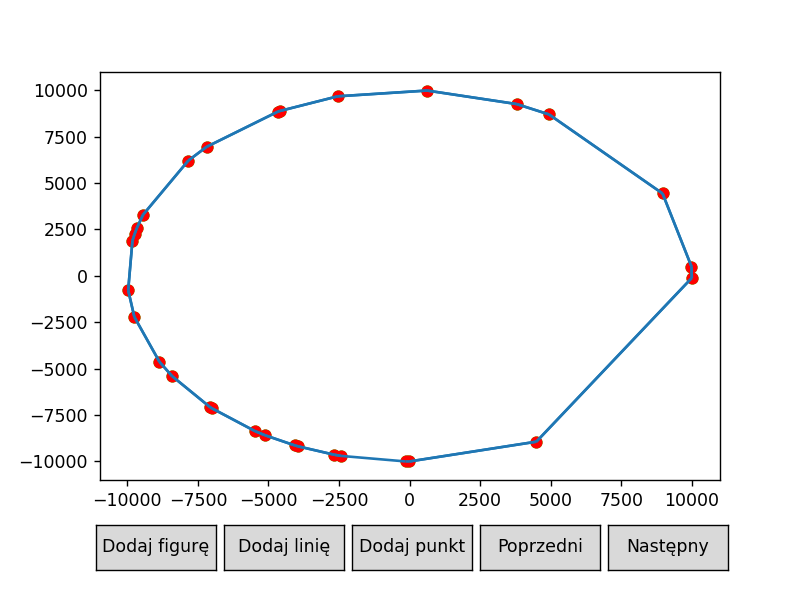

In [36]:
print(Graham(p2,False)) # True jeśli chcemy zapisać wynik w pliku, False w p. p.
plotg=Plot(scenes = scenes)
plotg.draw() 

[(0, 0), (99967.08895915197, 2565.370350065786), (99885.6433392035, 4781.030716637757), (99585.57195065638, 9094.716007696108), (99007.24275012822, 14055.81313966511), (98459.31184569333, 17486.10622387138), (98140.3451907259, 19195.641324143475), (97417.85036358528, 22577.91909229252), (96274.04468730296, 27042.71287328979), (96198.70671794857, 27309.500650764672), (94972.18559147435, 31309.48680477776), (92998.81968734671, 36758.938188695996), (91988.54252314275, 39218.72058683146), (91941.51603266638, 39328.8396677928), (89612.73337714189, 44379.70275562105), (87791.63943817496, 47881.395601605895), (87595.44053515344, 48239.39051700796), (87441.81675243609, 48517.3029241464), (86402.00051859266, 50345.74764947992), (85721.98323908453, 51495.06373972277), (85573.40920802577, 51741.58517590826), (85004.50560587227, 52670.99796568534), (83186.37263557233, 55497.99462805573), (82425.65218436086, 56621.655415421825), (81883.57175545994, 57402.79328193396), (81732.88517378706, 57617.1457

<IPython.core.display.Javascript object>


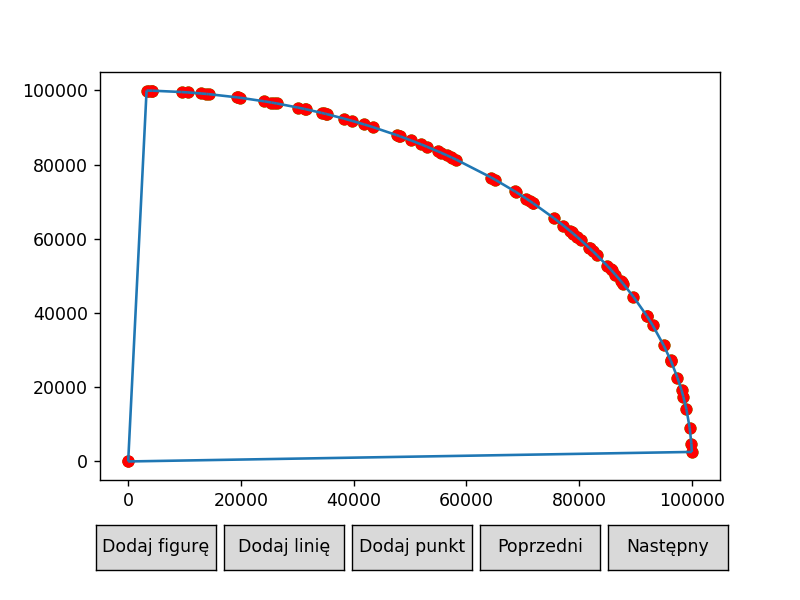

In [37]:
print(Jarvis(p5,False))
plotj=Plot(scenes=scenesj)
plotj.draw()

[(49.28706049546793, 99.68839314654502), (-97.34027628392448, 98.5126508097459), (-98.48669530358613, 87.33663649637762), (-98.7605875787662, 75.60787152517418), (-99.38248931055892, 36.97345793146482), (-99.6339645207661, -24.598523100995678), (-98.0342610576914, -78.72363580838142), (-91.60514964924222, -98.27336734521319), (-74.29278642547752, -99.41142384358044), (-41.67807321087107, -99.98102123432598), (92.12153264094059, -99.98490224647946), (99.07992872394342, -86.07774523119495), (99.91760798704519, 6.750006058241027), (98.18765469108513, 87.79480907308493), (82.07502308379773, 96.82184829182495)]


<IPython.core.display.Javascript object>


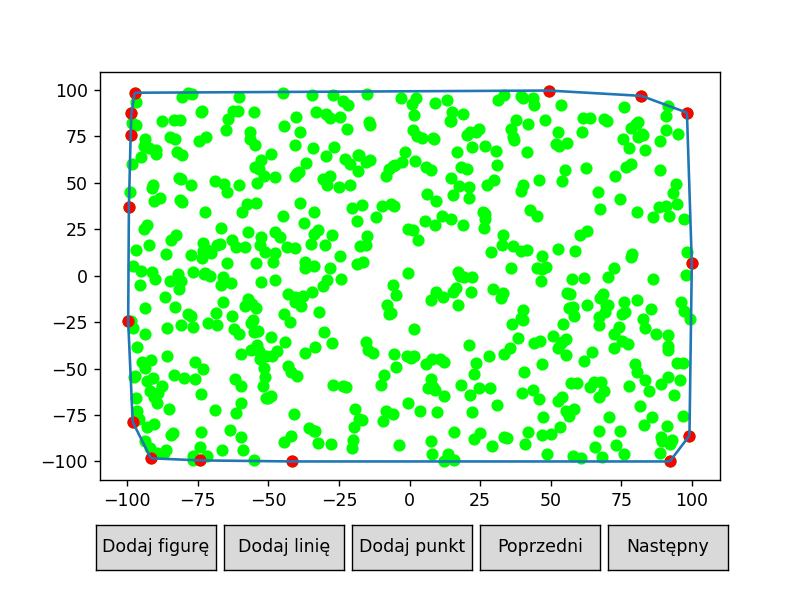

In [38]:
print(Incremental(p1,False))
ploti=Plot(scenes=scenesi)
ploti.draw()

[(-99.6339645207661, -24.598523100995678), (-98.0342610576914, -78.72363580838142), (-91.60514964924222, -98.27336734521319), (-74.29278642547752, -99.41142384358044), (-41.67807321087107, -99.98102123432598), (92.12153264094059, -99.98490224647946), (99.07992872394342, -86.07774523119495), (99.91760798704519, 6.750006058241027), (98.18765469108513, 87.79480907308493), (82.07502308379773, 96.82184829182495), (49.28706049546793, 99.68839314654502), (-97.34027628392448, 98.5126508097459), (-98.48669530358613, 87.33663649637762), (-98.7605875787662, 75.60787152517418), (-99.38248931055892, 36.97345793146482)]


<IPython.core.display.Javascript object>


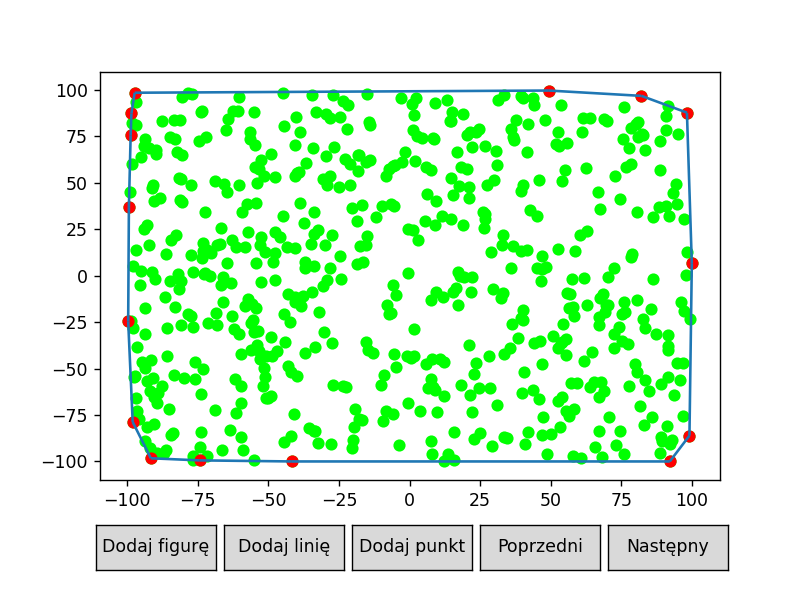

In [39]:
print(UpperLowerHull(p1,False))
plotul = Plot(scenes=scenesul)
plotul.draw()

[(-99.6339645207661, -24.598523100995678), (-98.0342610576914, -78.72363580838142), (-91.60514964924222, -98.27336734521319), (-74.29278642547752, -99.41142384358044), (-41.67807321087107, -99.98102123432598), (92.12153264094059, -99.98490224647946), (99.07992872394342, -86.07774523119495), (99.91760798704519, 6.750006058241027), (98.18765469108513, 87.79480907308493), (82.07502308379773, 96.82184829182495), (49.28706049546793, 99.68839314654502), (-97.34027628392448, 98.5126508097459), (-98.48669530358613, 87.33663649637762), (-98.7605875787662, 75.60787152517418), (-99.38248931055892, 36.97345793146482)]


<IPython.core.display.Javascript object>


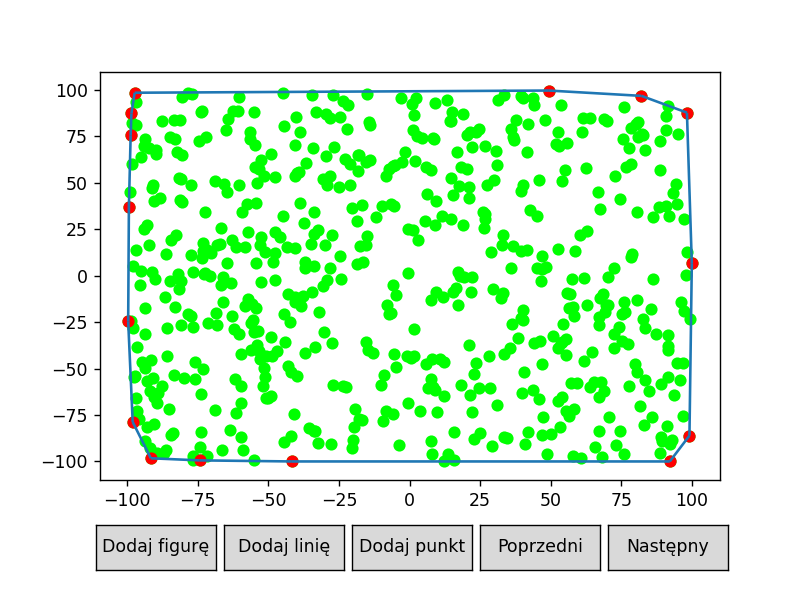

In [40]:
# niebieski - wszystkie punkty
# zielony - rozważane
# żółty - punkty A,B
# magenta - aktualnie najbardziej odległy
# niebieska linia - badany odcinek
# czerwone linie - "nowe" linie tymczasowej otoczki

print(QHull(p1,False))
plotq=Plot(scenes=scenesq)
plotq.draw()

[(92.12153264094059, -99.98490224647946), (99.07992872394342, -86.07774523119495), (99.91760798704519, 6.750006058241027), (98.18765469108513, 87.79480907308493), (82.07502308379773, 96.82184829182495), (49.28706049546793, 99.68839314654502), (-97.34027628392448, 98.5126508097459), (-98.48669530358613, 87.33663649637762), (-98.7605875787662, 75.60787152517418), (-99.38248931055892, 36.97345793146482), (-99.6339645207661, -24.598523100995678), (-98.0342610576914, -78.72363580838142), (-91.60514964924222, -98.27336734521319), (-74.29278642547752, -99.41142384358044), (-41.67807321087107, -99.98102123432598)]


<IPython.core.display.Javascript object>


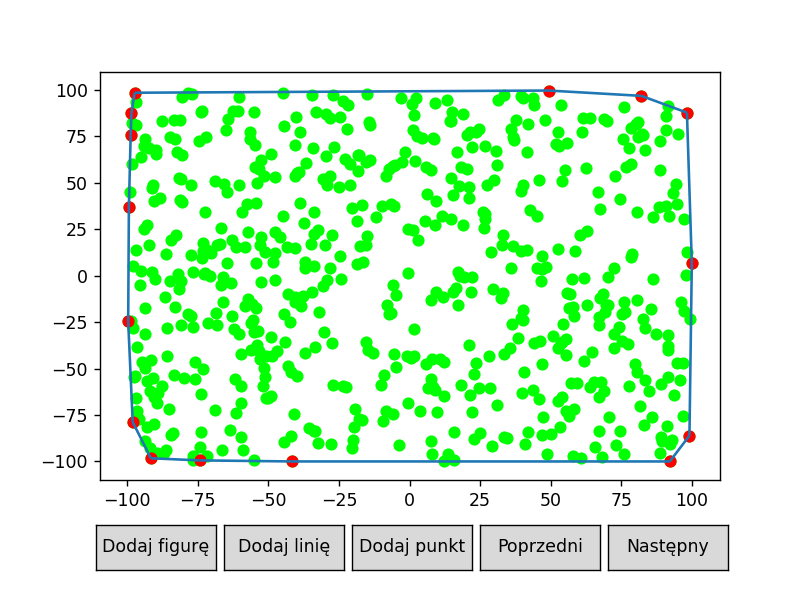

In [41]:
scenesd = []
hulls = []
points = []
print(DivideAndConquer(p1,False))
plotd=Plot(scenes=scenesd)
plotd.draw()

[(92.12153264094059, -99.98490224647946), (99.07992872394342, -86.07774523119495), (99.91760798704519, 6.750006058241027), (98.18765469108513, 87.79480907308493), (82.07502308379773, 96.82184829182495), (49.28706049546793, 99.68839314654502), (-97.34027628392448, 98.5126508097459), (-98.48669530358613, 87.33663649637762), (-98.7605875787662, 75.60787152517418), (-99.38248931055892, 36.97345793146482), (-99.6339645207661, -24.598523100995678), (-98.0342610576914, -78.72363580838142), (-91.60514964924222, -98.27336734521319), (-74.29278642547752, -99.41142384358044), (-41.67807321087107, -99.98102123432598)]


<IPython.core.display.Javascript object>


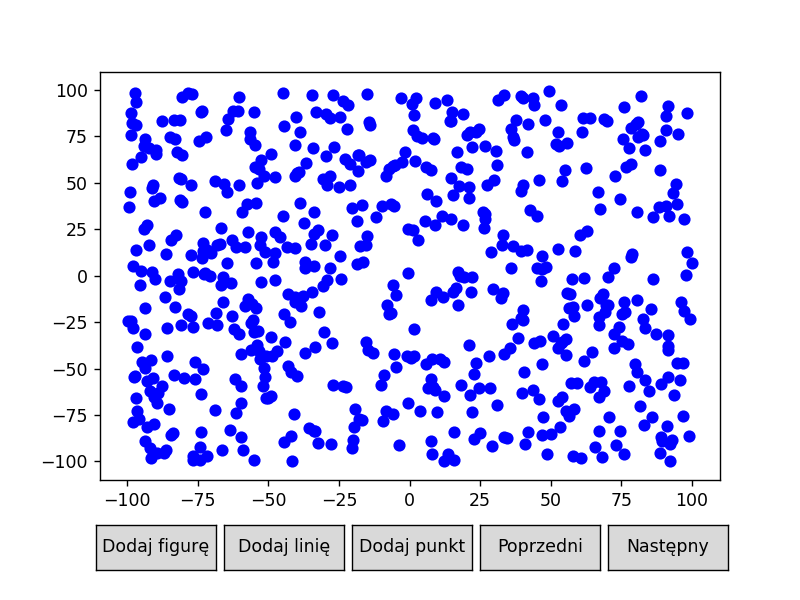

In [42]:
#p1.sort() #dla lepszej wizualizacji, gdy zbiór losowy
print(ChanHull(p1,False))
plotc=Plot(scenes=scenesc)
plotc.draw()

#### Algorytmy w wersji do pomiaru czasu

In [43]:
from time import time

s = p2 # wybór zbioru do pomiaru

# Graham

startg=time()
Graham_To_Measure_Time(s,False) # True jeśli chcemy zapisać wynik w pliku, False w p. p.
endg=time()
print("Czas działania algorytmu Grahama: ",endg-startg," sekund")

# Jarvis

startj=time()
Jarvis_To_Measure_Time(s,False)
endj=time()
print("Czas działania algorytmu Jarvisa: ",endj-startj," sekund")

# Przyrostowy

starti=time()
Incremental_To_Measure_Time(s,False)
endi=time()
print("Czas działania algorytmu przyrostowego: ",endi-starti," sekund")

# Górna i dolna otoczka

startul=time()
UpperLowerHull_To_Measure_Time(s,False)
endul=time()
print("Czas działania algorytmu górnej i dolnej otoczki: ",endul-startul," sekund")

# QuickHull

startq=time()
QHull_To_Measure_Time(s,False)
endq=time()
print("Czas działania algorytmu QuickHull: ",endq-startq," sekund")

# Dziel i zwyciężaj

startd=time()
DivideAndConquer_To_Measure_Time(s,False)
endd=time()
print("Czas działania algorytmu dziel i zwyciężaj: ",endd-startd," sekund")

# Chan

startc=time()
ChanHull_To_Measure_Time(s,False)
endc=time()
print("Czas działania algorytmu Chana: ",endc-startc," sekund")

Czas działania algorytmu Grahama:  0.0010285377502441406  sekund
Czas działania algorytmu Jarvisa:  0.001999378204345703  sekund
Czas działania algorytmu przyrostowego:  0.0030548572540283203  sekund
Czas działania algorytmu górnej i dolnej otoczki:  0.0  sekund
Czas działania algorytmu QuickHull:  0.0010418891906738281  sekund
Czas działania algorytmu dziel i zwyciężaj:  0.0  sekund
Czas działania algorytmu Chana:  0.0020003318786621094  sekund


In [108]:
from time import time
from pandas import DataFrame

amount = 50
graham = []
jarvis = []
increment = []
upperlower = []
quickhull = []
divide = []
chan = []
s=p3
    
for i in range(1,amount):
    rand3_time(i*100,(0,100),(100,100),(100,0),(0,0))
    
    # Graham
    
    startg=time()
    Graham_To_Measure_Time(s,False) # True jeśli chcemy zapisać wynik w pliku, False w p. p.
    endg=time()
    graham.append(endg-startg)

    # Jarvis

    startj=time()
    Jarvis_To_Measure_Time(s,False)
    endj=time()
    jarvis.append(endj-startj)

    # Przyrostowy

    starti=time()
    Incremental_To_Measure_Time(s,False)
    endi=time()
    increment.append(endi-starti)

    # Górna i dolna otoczka

    startul=time()
    UpperLowerHull_To_Measure_Time(p3,False)
    endul=time()
    upperlower.append(endul-startul)

    # QuickHull

    startq=time()
    QHull_To_Measure_Time(s,False)
    endq=time()
    quickhull.append(endq-startq)

    # Dziel i zwyciężaj

    startd=time()
    DivideAndConquer_To_Measure_Time(s,False)
    endd=time()
    divide.append(endd-startd)

    # Chan

    startc=time()
    ChanHull_To_Measure_Time(s,False)
    endc=time()
    chan.append(endc-startc)
    
    print(i)
    
#df = DataFrame({"Graham":graham, "Jarvis":jarvis, "Incremental":increment, "Upper Lower Hull":upperlower, "QuickHull":quickhull,
#               "Divide And Conquer":divide, "Chan":chan})
df = DataFrame({"Graham":graham, "Jarvis":jarvis, "Incremental":increment, "Upper Lower Hull":upperlower, "QuickHull":quickhull})
df.to_excel("test.xlsx", sheet_name="Arkusz1", index=False)
    
print("end")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
end
